# [Neural CDE](https://docs.kidger.site/diffrax/examples/neural_cde/)
Neural CDE は次のような式で表現されるモデルである。

$$y(t) = y(0) + \int_0^t f_\theta(y(s)) \frac{\mathrm{d}x}{\mathrm{d}s}(s) \mathrm{d}s$$

ここでは、 Neural CDE を用いて時計回りの渦と、反時計回りの渦の分類を行う。

In [1]:
import math
import time
from typing import Optional

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp
from jaxtyping import Array, PRNGKeyArray
import matplotlib
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

from tools._dataset.datasets import make_2dspiral_dataset
from tools._dataset.dataloader import dataloader
from tools._modules.vector_field import Func

## ベクトル場
`01_controlled_differential_equations` と同様に、まずはベクトル場を定義する。今回は未知の真なるベクトル場を Neural Network で近似する。

`equinox.nn.MLP` では、入力層のノード数 `in_size`、中間層のノード数 `width_size`、出力層のノード数 `out_size`、さらに層数 `depth` を指定することで、MLPを初期化できる。また `activation` は各中間層につける活性化関数、 `final_activation` は出力層につける活性化関数を指定するための引数である。

ベクトル場は $f_\theta: \mathbb{R}^{d_y} \rightarrow \mathbb{R}^{d_y \times d_x}$ で与えられるものなので、入力サイズは `hidden_size` で、出力サイズ `hidden_size * in_size` となっている。（`in_size` = $d_x$, `hidden_size` = $d_y$）

class Func(eqx.Module):
    """
        ベクトル場を定義.
    """
    mlp: eqx.nn.MLP
    in_size: int
    hidden_size: int

    def __init__(self, in_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.mlp = eqx.nn.MLP(
            in_size=hidden_size,
            out_size=hidden_size * in_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            # Note the use of a tanh final activation function. This is important to
            # stop the model blowing up. (Just like how GRUs and LSTMs constrain the
            # rate of change of their hidden states.)
            final_activation=jnn.tanh,
            key=key,
        )

    def __call__(self, t: Optional[Array], y: Array, args: Optional[Array] = None):
        return self.mlp(y).reshape(self.hidden_size, self.in_size)

## Neural CDE
Neural CDE モデルを定義している.

In [2]:
class NeuralCDE(eqx.Module):
    """
        Neural CDE モデルを定義.
    """
    initial: eqx.nn.MLP
    func: Func
    linear: eqx.nn.Linear

    def __init__(self, in_size, out_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        ikey, fkey, lkey = jr.split(key, 3) # 乱数生成キーを分割し, 独立した新たなキーを作成
        self.initial = eqx.nn.MLP(in_size, hidden_size, width_size, depth, key=ikey) # 初期条件のモデルを初期化
        self.func = Func(in_size, hidden_size, width_size, depth, key=fkey) # ベクトル場のモデルを初期化
        self.linear = eqx.nn.Linear(hidden_size, out_size, key=lkey) # 出力層のモデルを初期化

    def __call__(self, ts, coeffs, evolving_out=False):
        # Each sample of data consists of some timestamps `ts`, and some `coeffs`
        # parameterising a control path. These are used to produce a continuous-time
        # input path `control`.
        control = diffrax.CubicInterpolation(ts, coeffs) # 制御信号（パス）の生成
        term = diffrax.ControlTerm(self.func, control).to_ode() # Term の生成
        solver = diffrax.Tsit5() # ソルバー
        dt0 = None # 最初のステップに使用するステップサイズ
        y0 = self.initial(control.evaluate(ts[0])) # 積分区間の始点
        if evolving_out:
            saveat = diffrax.SaveAt(ts=ts)
        else:
            saveat = diffrax.SaveAt(t1=True)
        solution = diffrax.diffeqsolve(
            term,
            solver,
            ts[0],
            ts[-1],
            dt0,
            y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=saveat,
        ) # 微分方程式の解を計算
        if evolving_out:
            prediction = jax.vmap(lambda y: jnn.sigmoid(self.linear(y))[0])(solution.ys)
        else:
            (prediction,) = jnn.sigmoid(self.linear(solution.ys[-1]))
        return prediction

# Train and Eval

In [3]:
def main(
    dataset_size=4096,
    length=100,
    out_size=1,
    add_noise=False,
    batch_size=32,
    lr=3e-3,
    steps=100,
    hidden_size=8,
    width_size=128,
    depth=1,
    seed=5678,
):
    key = jr.PRNGKey(seed)
    train_data_key, test_data_key, model_key, loader_key = jr.split(key, 4)

    ts, _, coeffs, labels, in_size = make_2dspiral_dataset(
        dataset_size, length, add_noise, key=train_data_key
    )
    
    model = NeuralCDE(in_size, out_size, hidden_size, width_size, depth, key=model_key)

    # Training loop like normal.

    @eqx.filter_jit
    def loss(model, ti, label_i, coeff_i):
        pred = jax.vmap(model)(ti, coeff_i)
        # Binary cross-entropy
        bxe = label_i * jnp.log(pred) + (1 - label_i) * jnp.log(1 - pred)
        bxe = -jnp.mean(bxe)
        acc = jnp.mean((pred > 0.5) == (label_i == 1))
        return bxe, acc

    grad_loss = eqx.filter_value_and_grad(loss, has_aux=True)

    @eqx.filter_jit
    def make_step(model, data_i, opt_state):
        ti, label_i, *coeff_i = data_i
        (bxe, acc), grads = grad_loss(model, ti, label_i, coeff_i)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return bxe, acc, model, opt_state

    optim = optax.adam(lr)
    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
    for step, data_i in zip(
        range(steps), dataloader((ts, labels) + coeffs, batch_size, key=loader_key)
    ):
        start = time.time()
        bxe, acc, model, opt_state = make_step(model, data_i, opt_state)
        end = time.time()
        print(
            f"Step: {step}, Loss: {bxe}, Accuracy: {acc}, Computation time: "
            f"{end - start}"
        )

    ts, _, coeffs, labels, _ = make_2dspiral_dataset(dataset_size, length, add_noise, key=test_data_key)
    bxe, acc = loss(model, ts, labels, coeffs)
    print(f"Test loss: {bxe}, Test Accuracy: {acc}")

    # Plot results
    sample_ts = ts[-1]
    sample_coeffs = tuple(c[-1] for c in coeffs)
    pred = model(sample_ts, sample_coeffs, evolving_out=True)
    interp = diffrax.CubicInterpolation(sample_ts, sample_coeffs)
    values = jax.vmap(interp.evaluate)(sample_ts)
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection="3d")
    ax1.plot(sample_ts, values[:, 1], c="dodgerblue")
    ax1.plot(sample_ts, values[:, 2], c="dodgerblue", label="Data")
    ax1.plot(sample_ts, pred, c="crimson", label="Classification")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_xlabel("t")
    ax1.legend()
    ax2.plot(values[:, 1], values[:, 2], c="dodgerblue", label="Data")
    ax2.plot(values[:, 1], values[:, 2], pred, c="crimson", label="Classification")
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("Classification")
    plt.tight_layout()
    plt.savefig("./figures/neural_cde.png")
    plt.show()

Step: 0, Loss: 2.9369773864746094, Accuracy: 0.46875, Computation time: 2.5239551067352295
Step: 1, Loss: 0.8011254072189331, Accuracy: 0.4375, Computation time: 0.09046602249145508
Step: 2, Loss: 1.0048739910125732, Accuracy: 0.28125, Computation time: 0.08316898345947266
Step: 3, Loss: 0.689410924911499, Accuracy: 0.40625, Computation time: 0.08959197998046875
Step: 4, Loss: 0.6281055212020874, Accuracy: 0.59375, Computation time: 0.08662915229797363
Step: 5, Loss: 0.5501775741577148, Accuracy: 0.59375, Computation time: 0.08417415618896484
Step: 6, Loss: 0.4396094083786011, Accuracy: 0.875, Computation time: 0.10181474685668945
Step: 7, Loss: 0.42271238565444946, Accuracy: 1.0, Computation time: 0.07821273803710938
Step: 8, Loss: 0.4029387831687927, Accuracy: 1.0, Computation time: 0.12295103073120117
Step: 9, Loss: 0.31830090284347534, Accuracy: 1.0, Computation time: 0.09702897071838379
Step: 10, Loss: 0.2758498191833496, Accuracy: 1.0, Computation time: 0.09054398536682129
Step: 

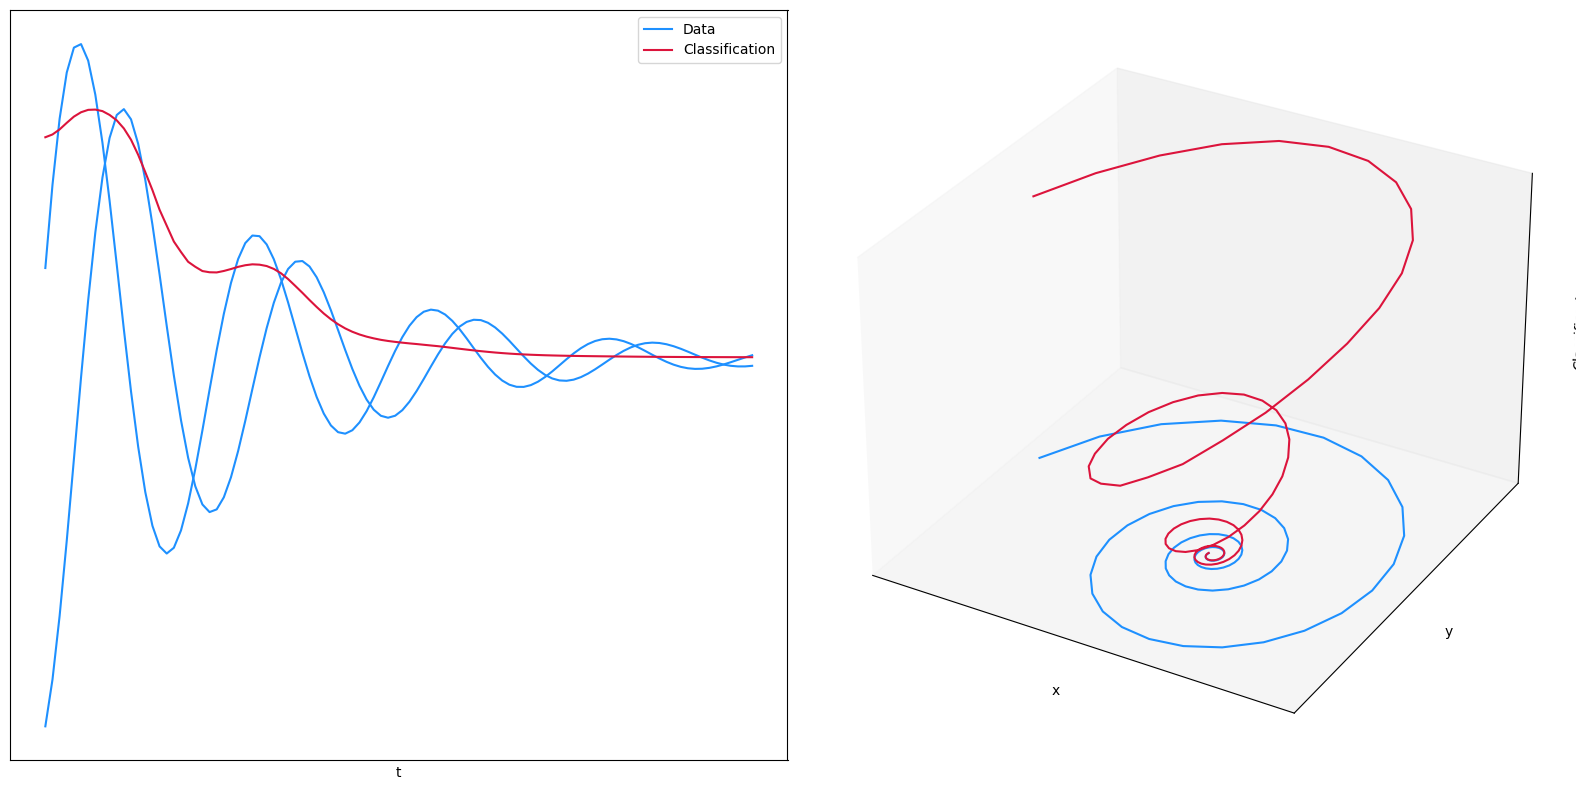

In [4]:
main()